In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MultiLabelBinarizer
from torch_geometric.loader import LinkNeighborLoader
import torch
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# import tqdm
# import torch.nn.functional as F
# from torch import Tensor
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
print(torch.__version__)
import src.link_predict_sageconv as sageconv
import src.link_predict_gat as gat
from src.link_predict_val_metrics import validation_metrics, precision_at_k

2.0.0


# Networkx Graph

In [2]:
node2idx2 = pd.read_csv('./data/Reduced graph/node_idx.csv')
edge_data = pd.read_csv('./data/Reduced graph/edge_data.csv')

In [3]:
node_id = node2idx2['Node id'].to_list()
node_name = node2idx2['Node name'].to_list()
node2idx = {}
for i in range(len(node_id)):
    node2idx[node_name[i]] = node_id[i]

def edge_idx(df):
    sup = node2idx[df["compiledRelease/awards/0/suppliers/0/id"]]
    buy = node2idx[df["compiledRelease/buyer/id"]]
    return (buy, sup)

edge_data['Edge Rep'] = edge_data.apply(edge_idx, axis=1)

In [4]:
# Create a bipartite graph
G = nx.Graph()

num_inst = node2idx2['Node type'].value_counts()['institution']
nodes = list(node2idx.values())

nodes_set_A = nodes[:num_inst] #instituciones
nodes_set_B = nodes[num_inst:] #proveedores

# Add nodes to the graph with 'bipartite' attribute
G.add_nodes_from(nodes_set_A, bipartite=0)  # bipartite=0 for nodes in set A
G.add_nodes_from(nodes_set_B, bipartite=1)  # bipartite=1 for nodes in set B

# Add edges between nodes in different sets
edges = [tuple(x) for x in edge_data['Edge Rep']]
#edges = edge_data['Edge Rep'].to_list()
G.add_edges_from(edges)

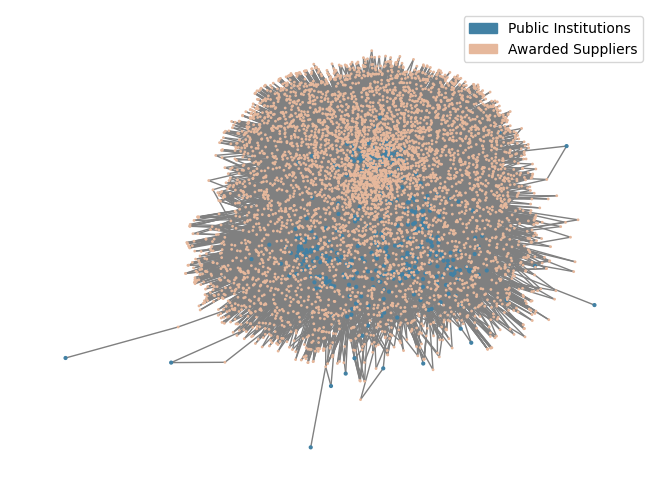

In [5]:
# Create dictionaries to specify node sizes for each partition
node_sizes_A = {node: 4 for node in nodes_set_A}

# Create dictionaries to specify colors for nodes in each partition
node_colors = {node: '#4281A4' for node in nodes_set_A}
node_colors.update({node: '#E6B89C' for node in nodes_set_B})

# Create a dictionary to specify colors for edges
edge_colors = {edge: 'gray' for edge in G.edges()}

# Visualize the bipartite graph
pos = nx.spring_layout(G, seed=42)

# Extract lists of sizes and colors for nodes and edges based on the dictionaries
node_sizes_list = [node_sizes_A.get(node, 1) for node in G.nodes()]
node_colors_list = [node_colors[node] for node in G.nodes()]
edge_colors_list = [edge_colors[edge] for edge in G.edges()]

# Draw the graph with specified node and edge colors
nx.draw(G, pos, node_color=node_colors_list, edge_color=edge_colors_list, node_size=node_sizes_list)

# Create legend patches for node colors
legend_patches = [
    mpatches.Patch(color='#4281A4', label='Public Institutions'),
    mpatches.Patch(color='#E6B89C', label='Awarded Suppliers'),
]

# Add the legend to the plot
plt.legend(handles=legend_patches)

# Display the plot
plt.show()

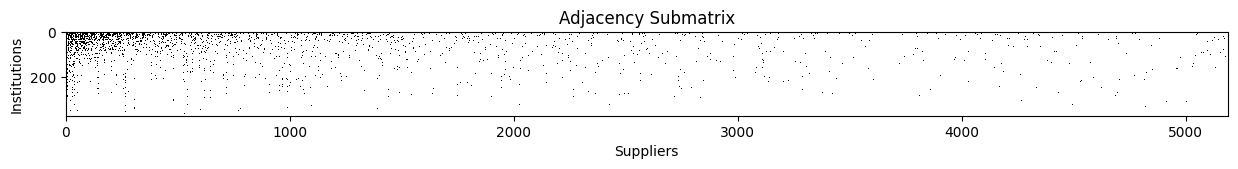

In [5]:
A = nx.adjacency_matrix(G)
A = A.toarray()

# Extract the submatrix with rows from set A and columns from set B
adjacency_submatrix = A[nodes_set_A][:, nodes_set_B]

plt.figure(figsize=(15, 10))
plt.title("Adjacency Submatrix")
plt.xlabel('Suppliers')
plt.ylabel('Institutions')
plt.imshow(adjacency_submatrix, cmap='binary', interpolation='none')
plt.show()


# Pytorch Geometric Graph

## Edges adaptation

In [6]:
edge_list = np.array(list(nx.edges(G)))
edge_list = np.array([[a,b-(1+np.max(edge_list[:,0]))] for a,b in edge_list])
edge_list = edge_list.T

In [7]:
edge_list.shape

(2, 39772)

In [8]:
edge_index_inst_to_supp = torch.from_numpy(edge_list)
size_x, size_y = edge_list.shape
assert edge_index_inst_to_supp.size() == (size_x, size_y)
edge_index_inst_to_supp

tensor([[   0,    0,    0,  ...,  371,  372,  373],
        [ 529,  749,   54,  ..., 1816,  273,   54]])

## Nodes Features

### Institution Features (25 features)

In [9]:
institution_features = pd.read_csv('./data/category_vs_institution.csv')
node2idx2 = pd.read_csv('./data/Reduced graph/node_idx.csv')
institution_features = institution_features[['compiledRelease/buyer/id', 'ID_cat']]

institution_features.head()

,compiledRelease/buyer/id,ID_cat
0,DNCP-SICP-CODE-230,Cat14
1,DNCP-SICP-CODE-176,Cat14
2,DNCP-SICP-CODE-331,Cat14
3,DNCP-SICP-CODE-305,Cat14
4,DNCP-SICP-CODE-127,Cat14


In [10]:
institution_features['ID_cat'].unique()

array(['Cat14', 'Cat9', 'Cat5', 'Cat11', 'Cat21', 'Cat12', 'Cat23',
       'Cat1', 'Cat6', 'Cat25', 'Cat19', 'Cat18', 'Cat13', 'Cat22',
       'Cat4', 'Cat10', 'Cat7', 'Cat8', 'Cat20', 'Cat15', 'Cat16', 'Cat2',
       'Cat17', 'Cat24', 'Cat3'], dtype=object)

In [11]:
inst = institution_features['compiledRelease/buyer/id'].to_list()
feat_inst = institution_features['ID_cat'].to_list()

inst_node_features = {}

for i in range(institution_features.shape[0]):
    if inst[i] in inst_node_features:
        inst_node_features[inst[i]].append(feat_inst[i])
    else:
        inst_node_features[inst[i]] = [feat_inst[i]]


In [12]:
df_inst_features = node2idx2[node2idx2['Node type']=='institution']
df_inst_features = df_inst_features[['Node name', 'ID in Category']]
df_inst_features['features'] = df_inst_features.apply(lambda row: inst_node_features[row['Node name']], axis=1)
df_inst_features.reset_index(drop=True, inplace=True)

In [13]:
mlb = MultiLabelBinarizer()
inst_labels_matrix = mlb.fit_transform(df_inst_features['features'])
inst_labels_df = pd.DataFrame(inst_labels_matrix, columns=mlb.classes_)

df_inst_features = pd.concat([df_inst_features, inst_labels_df], axis=1)
df_inst_features.drop(['features'], axis=1, inplace=True)
sort_col = list(df_inst_features.columns)[:2] + ['Cat'+str(i) for i in range(1, len(df_inst_features.columns)-1)]
df_inst_features = df_inst_features[sort_col]
df_inst_features.head()

,Node name,ID in Category,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,...,Cat16,Cat17,Cat18,Cat19,Cat20,Cat21,Cat22,Cat23,Cat24,Cat25
0,DNCP-SICP-CODE-306,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,DNCP-SICP-CODE-301,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,DNCP-SICP-CODE-226,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,DNCP-SICP-CODE-304,3,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,DNCP-SICP-CODE-21,4,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [14]:
inst_feat_data = df_inst_features.drop(['Node name'], axis=1)
inst_feat_data.rename({'ID in Category':'instID'}, axis=1, inplace=True)
inst_feat_data.set_index('instID', inplace=True)
inst_feat_data.head()

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,...,Cat16,Cat17,Cat18,Cat19,Cat20,Cat21,Cat22,Cat23,Cat24,Cat25
instID,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
inst_feat = torch.from_numpy(inst_feat_data.values).to(torch.float)
size_x, size_y = inst_feat_data.shape
assert inst_feat.size() == (size_x, size_y)  # 25 categories in total.
inst_feat

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Supplier Features (25 features)

In [16]:
supplier_features = pd.read_csv('./data/category_vs_supplier.csv')
node2idx2 = pd.read_csv('./data/Reduced graph/node_idx.csv')
supplier_features = supplier_features[['compiledRelease/awards/0/suppliers/0/id', 'ID_cat']]

supplier_features.head()

,compiledRelease/awards/0/suppliers/0/id,ID_cat
0,PY-RUC-80012330-1,Cat10
1,PY-RUC-80030030-0,Cat10
2,PY-RUC-80026564-5,Cat10
3,PY-RUC-80000173-7,Cat10
4,PY-RUC-80025797-9,Cat10


In [17]:
supp = supplier_features['compiledRelease/awards/0/suppliers/0/id'].to_list()
feat = supplier_features['ID_cat'].to_list()

node_features = {}

for i in range(supplier_features.shape[0]):
    if supp[i] in node_features:
        node_features[supp[i]].append(feat[i])
    else:
        node_features[supp[i]] = [feat[i]]

In [18]:
df_supplier_features = node2idx2[node2idx2['Node type']=='supplier']
df_supplier_features = df_supplier_features[['Node name', 'ID in Category']]
df_supplier_features['features'] = df_supplier_features.apply(lambda row: node_features[row['Node name']], axis=1)
df_supplier_features.reset_index(drop=True, inplace=True)

In [19]:
mlb = MultiLabelBinarizer()
supplier_labels_matrix = mlb.fit_transform(df_supplier_features['features'])
supplier_labels_df = pd.DataFrame(supplier_labels_matrix, columns=mlb.classes_)

df_supplier_features = pd.concat([df_supplier_features, supplier_labels_df], axis=1)
df_supplier_features.drop(['features'], axis=1, inplace=True)
sort_col2 = list(df_supplier_features.columns)[:2] + ['Cat'+str(i) for i in range(1, len(df_supplier_features.columns)-1)]
df_supplier_features = df_supplier_features[sort_col2]
df_supplier_features.head()

,Node name,ID in Category,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,...,Cat16,Cat17,Cat18,Cat19,Cat20,Cat21,Cat22,Cat23,Cat24,Cat25
0,PY-RUC-80013889-9,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
1,PY-RUC-80002612-8,1,1,0,0,0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
2,PY-RUC-80002592-0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,PY-RUC-80002756-6,3,0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,1,1,1
4,PY-RUC-80003251-9,4,1,0,0,1,0,0,1,1,...,0,0,0,0,0,1,1,0,0,0


In [20]:
supp_feat_data = df_supplier_features.drop(['Node name'], axis=1)
supp_feat_data.rename({'ID in Category':'instID'}, axis=1, inplace=True)
supp_feat_data.set_index('instID', inplace=True)
supp_feat_data.head()

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,...,Cat16,Cat17,Cat18,Cat19,Cat20,Cat21,Cat22,Cat23,Cat24,Cat25
instID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,1,1,0,0,1
1,1,0,0,0,1,0,0,1,1,1,...,0,0,1,0,0,1,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,1,1,1,1,...,0,1,0,0,0,0,0,1,1,1
4,1,0,0,1,0,0,1,1,1,0,...,0,0,0,0,0,1,1,0,0,0


In [21]:
supp_feat = torch.from_numpy(supp_feat_data.values).to(torch.float)
size_x, size_y = supp_feat_data.shape
assert supp_feat.size() == (size_x, size_y)  # 25 categories in total.
supp_feat

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Supplier Features pt. 2 (9 features)

In [22]:
supplier_features2 = pd.read_csv('./data/type_inst_vs_supplier.csv')
node2idx2 = pd.read_csv('./data/Reduced graph/node_idx.csv')
supplier_features2 = supplier_features2[['compiledRelease/awards/0/suppliers/0/id', 'Category']]

supplier_features2.head()

,compiledRelease/awards/0/suppliers/0/id,Category
0,PY-RUC-575869-6,University
1,PY-RUC-80031893-5,University
2,PY-RUC-1401453-0,University
3,PY-RUC-1257422-8,University
4,PY-RUC-80013889-9,University


In [23]:
supp2 = supplier_features2['compiledRelease/awards/0/suppliers/0/id'].to_list()
feat2 = supplier_features2['Category'].to_list()

node_features = {}

for i in range(supplier_features2.shape[0]):
    if supp2[i] in node_features:
        node_features[supp2[i]].append(feat2[i])
    else:
        node_features[supp2[i]] = [feat2[i]]

In [24]:
df_supplier_features2 = node2idx2[node2idx2['Node type']=='supplier']
df_supplier_features2 = df_supplier_features2[['Node name', 'ID in Category']]
df_supplier_features2['features'] = df_supplier_features2.apply(lambda row: node_features[row['Node name']], axis=1)
df_supplier_features2.reset_index(drop=True, inplace=True)

In [25]:
mlb = MultiLabelBinarizer()
supplier_labels_matrix = mlb.fit_transform(df_supplier_features2['features'])
supplier_labels_df2 = pd.DataFrame(supplier_labels_matrix, columns=mlb.classes_)

df_supplier_features2 = pd.concat([df_supplier_features2, supplier_labels_df2], axis=1)
df_supplier_features2.drop(['features'], axis=1, inplace=True)
df_supplier_features2.head()

,Node name,ID in Category,Department Government,Descentralized Administration,Independent Institution,Judicial Branch,Legislative Branch,Ministry,Municipality,Retirement fund,University
0,PY-RUC-80013889-9,0,1,1,1,1,1,1,1,1,1
1,PY-RUC-80002612-8,1,1,1,1,1,1,1,1,0,1
2,PY-RUC-80002592-0,2,1,1,0,0,0,1,1,0,1
3,PY-RUC-80002756-6,3,1,1,1,1,1,1,1,1,1
4,PY-RUC-80003251-9,4,1,1,1,1,1,1,1,0,1


In [26]:
supp_feat_data2 = df_supplier_features2.drop(['Node name'], axis=1)
supp_feat_data2.rename({'ID in Category':'instID'}, axis=1, inplace=True)
supp_feat_data2.set_index('instID', inplace=True)
supp_feat_data2.head()

,Department Government,Descentralized Administration,Independent Institution,Judicial Branch,Legislative Branch,Ministry,Municipality,Retirement fund,University
instID,,,,,,,,,
0,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,0,1
2,1,1,0,0,0,1,1,0,1
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,0,1


In [27]:
supp_feat2 = torch.from_numpy(supp_feat_data2.values).to(torch.float)
size_x, size_y = supp_feat_data2.shape
assert supp_feat2.size() == (size_x, size_y)  
supp_feat2

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 0.,  ..., 1., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [28]:
merge_supp_feat = torch.hstack([supp_feat, supp_feat2])

In [29]:
features = (inst_feat, supp_feat, merge_supp_feat)
feat_data = (inst_feat_data, supp_feat_data)

## Object Creation

In [30]:
def bipartite_graph_creation(feat_data, features, edge_index_inst_to_supp, large_features):

    data = HeteroData()

    inst_feat_data, supp_feat_data = feat_data

    # Save node indices:
    data["institution"].node_id = torch.arange(inst_feat_data.shape[0])
    data["supplier"].node_id = torch.arange(supp_feat_data.shape[0])

    inst_feat, supp_feat, merge_supp_feat = features

    # Add the node features and edge indices:
    data["institution"].x = inst_feat
    if not large_features:
        data["supplier"].x = supp_feat
    else:
        data["supplier"].x = merge_supp_feat
    data["institution", "rates", "supplier"].edge_index = edge_index_inst_to_supp

    # We also need to make sure to add the reverse edges from movies to users
    # in order to let a GNN be able to pass messages in both directions.
    # We can leverage the `T.ToUndirected()` transform for this from PyG:
    data = T.ToUndirected()(data)

    assert data.node_types == ["institution", "supplier"]
    assert data.edge_types == [("institution", "rates", "supplier"),
                            ("supplier", "rev_rates", "institution")]
    assert data["institution"].num_nodes == inst_feat_data.shape[0]
    assert data["institution"].num_features == inst_feat_data.shape[1]
    if not large_features:
        assert data["supplier"].num_nodes == supp_feat_data.shape[0]
        assert data["supplier"].num_features == supp_feat_data.shape[1]
    else:
        assert data["supplier"].num_nodes == merge_supp_feat.shape[0]
        assert data["supplier"].num_features == merge_supp_feat.shape[1]
    assert data["institution", "rates", "supplier"].num_edges == edge_list.shape[1]
    assert data["supplier", "rev_rates", "institution"].num_edges == edge_list.shape[1]

    return data

# Modeling with Pytorch Geometric Graph

In [31]:
def split_train_validation(data, neg_samples=False):
    transform = T.RandomLinkSplit(
        num_val=0.2,
        num_test=0.2,
        disjoint_train_ratio=0.3,
        neg_sampling_ratio=1.5,
        add_negative_train_samples=neg_samples,
        edge_types=("institution", "rates", "supplier"),
        rev_edge_types=("supplier", "rev_rates", "institution"), 
    )

    train_data, val_data, test_data = transform(data)

    return train_data, val_data, test_data

In [32]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# We can make use of the `loader.LinkNeighborLoader` from PyG:

def sample_data_loader(data, batch_size, shuffle=True, neg_samp_ratio=None):
    # Define seed edges:
    edge_label_index = data["institution", "rates", "supplier"].edge_label_index
    edge_label = data["institution", "rates", "supplier"].edge_label

    dat_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[20, 10],
        neg_sampling_ratio=neg_samp_ratio,
        edge_label_index=(("institution", "rates", "supplier"), edge_label_index),
        edge_label=edge_label,
        batch_size=batch_size,
        shuffle=shuffle,
    )

    sampled_data = next(iter(dat_loader))

    return sampled_data, dat_loader

# Experiments

## Link prediction w/ smaller node features dataset

### SAGEConv

In [33]:
LARGE_FEATURES = False #True if you want to use 34 features from suppliers or false to use only 25
NEG_SAMPLES = True
data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                         edge_index_inst_to_supp=edge_index_inst_to_supp, 
                         large_features=LARGE_FEATURES)
train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)


In [34]:
#Training
sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
model = sageconv.Model(hidden_channels=64, data=data, large_features=LARGE_FEATURES)
model = sageconv.sage_train(model, sampled_data, train_loader, NEG_SAMPLES)

Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 71.62it/s]


Epoch: 001, Loss: 0.6067


100%|██████████| 140/140 [00:01<00:00, 73.14it/s]


Epoch: 002, Loss: 0.5863


100%|██████████| 140/140 [00:02<00:00, 65.30it/s]


Epoch: 003, Loss: 0.5809


100%|██████████| 140/140 [00:01<00:00, 77.94it/s]

Epoch: 004, Loss: 0.5726


In [35]:
#Validation
val_sampled_data, val_loader = sample_data_loader(val_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, val_sampled_data, val_loader, set_seed=42)

100%|██████████| 52/52 [00:00<00:00, 100.92it/s]


{'roc_auc': 0.8659248288083097,
 'accuracy': 0.8015589640432487,
 'precision': 0.7568572160984363,
 'recall': 0.742393764143827}

In [36]:
test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 82.22it/s]


{'roc_auc': 0.8637362112340409,
 'accuracy': 0.7982398793060096,
 'precision': 0.7455156950672646,
 'recall': 0.7524515966809152}

100%|██████████| 52/52 [00:00<00:00, 81.52it/s]


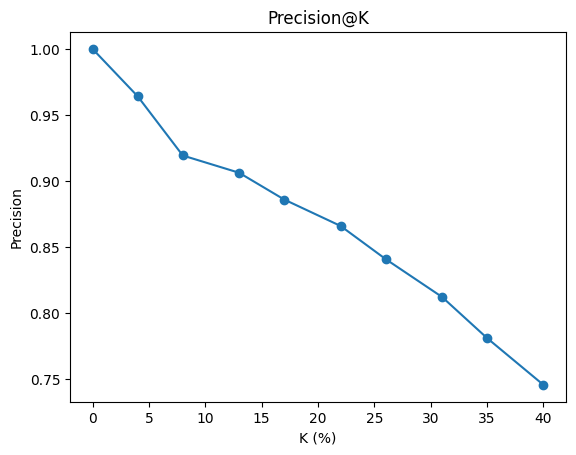

In [37]:
precision_values, total_k = precision_at_k(model, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()


### GAT

In [36]:
sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
model = gat.Model(hidden_channels=64, num_heads=4, data=data, large_features=LARGE_FEATURES)
model = gat.gat_train(model, sampled_data, train_loader, NEG_SAMPLES)

Device: 'cpu'


100%|██████████| 140/140 [00:07<00:00, 18.94it/s]


Epoch: 001, Loss: 0.6126


100%|██████████| 140/140 [00:08<00:00, 16.99it/s]


Epoch: 002, Loss: 0.5950


100%|██████████| 140/140 [00:07<00:00, 18.39it/s]


Epoch: 003, Loss: 0.5939


100%|██████████| 140/140 [00:07<00:00, 18.25it/s]

Epoch: 004, Loss: 0.6010


In [37]:
val_sampled_data, val_loader = sample_data_loader(val_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, val_sampled_data, val_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:01<00:00, 33.34it/s]


{'roc_auc': 0.7990455480676786,
 'accuracy': 0.7705305506663314,
 'precision': 0.7023994270025069,
 'recall': 0.7397535831028413}

In [38]:
test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:01<00:00, 31.02it/s]


{'roc_auc': 0.787573293314439,
 'accuracy': 0.7556449585114408,
 'precision': 0.6759922665756852,
 'recall': 0.7472969575056575}

100%|██████████| 52/52 [00:01<00:00, 30.60it/s]


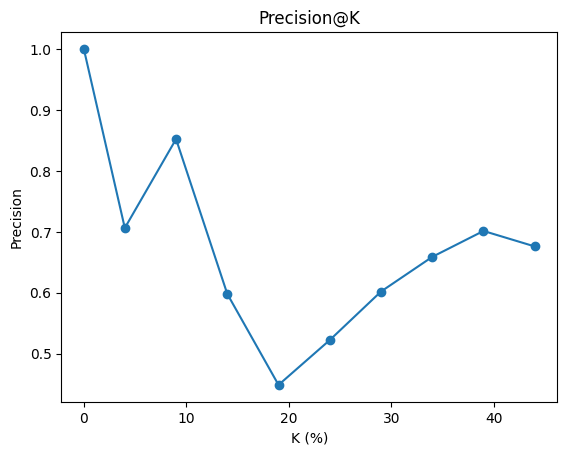

In [39]:
precision_values, total_k = precision_at_k(model, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()

## Link prediction w/ larger node features dataset

### SAGEConv

In [98]:
LARGE_FEATURES = True
NEG_SAMPLES = True
data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                         edge_index_inst_to_supp=edge_index_inst_to_supp, 
                         large_features=LARGE_FEATURES)
train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)

In [99]:
sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
model = sageconv.Model(hidden_channels=64, data=data, large_features=LARGE_FEATURES)
model = sageconv.sage_train(model, sampled_data, train_loader, NEG_SAMPLES)

Device: 'cpu'


  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:01<00:00, 73.16it/s]


Epoch: 001, Loss: 0.5988


100%|██████████| 140/140 [00:02<00:00, 64.72it/s]


Epoch: 002, Loss: 0.5770


100%|██████████| 140/140 [00:01<00:00, 74.50it/s]


Epoch: 003, Loss: 0.5713


100%|██████████| 140/140 [00:01<00:00, 74.75it/s]

Epoch: 004, Loss: 0.5664


In [100]:
val_sampled_data, val_loader = sample_data_loader(val_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, val_sampled_data, val_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 93.42it/s] 


{'roc_auc': 0.8861389510092048,
 'accuracy': 0.8192104601458385,
 'precision': 0.7982756261119475,
 'recall': 0.7333417148604475}

In [101]:
test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 87.90it/s]


{'roc_auc': 0.8901327423566406,
 'accuracy': 0.8216243399547397,
 'precision': 0.797167902899528,
 'recall': 0.7431481015841086}

100%|██████████| 52/52 [00:00<00:00, 85.03it/s]


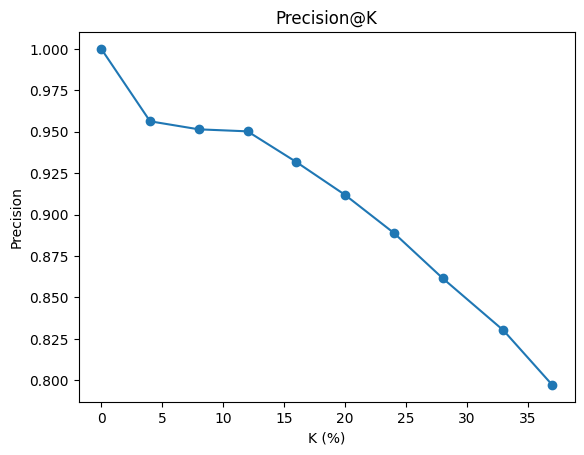

In [102]:
precision_values, total_k = precision_at_k(model, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()

### GAT

In [61]:
sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
model = gat.Model(hidden_channels=64, num_heads=4, data=data, large_features=LARGE_FEATURES)
model = gat.gat_train(model, sampled_data, train_loader, NEG_SAMPLES)

Device: 'cpu'


100%|██████████| 140/140 [00:08<00:00, 17.13it/s]


Epoch: 001, Loss: 0.6099


100%|██████████| 140/140 [00:07<00:00, 19.19it/s]


Epoch: 002, Loss: 0.6002


100%|██████████| 140/140 [00:06<00:00, 20.51it/s]


Epoch: 003, Loss: 0.5874


100%|██████████| 140/140 [00:07<00:00, 19.86it/s]

Epoch: 004, Loss: 0.5926


In [62]:
val_sampled_data, val_loader = sample_data_loader(val_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, val_sampled_data, val_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:01<00:00, 38.60it/s]


{'roc_auc': 0.7944833745339028,
 'accuracy': 0.7664068393261252,
 'precision': 0.6857944974733295,
 'recall': 0.7677897912999748}

In [63]:
test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:01<00:00, 33.76it/s]


{'roc_auc': 0.7872643917849063,
 'accuracy': 0.7546894644204174,
 'precision': 0.667028670721112,
 'recall': 0.772190093034951}

100%|██████████| 52/52 [00:01<00:00, 32.48it/s]


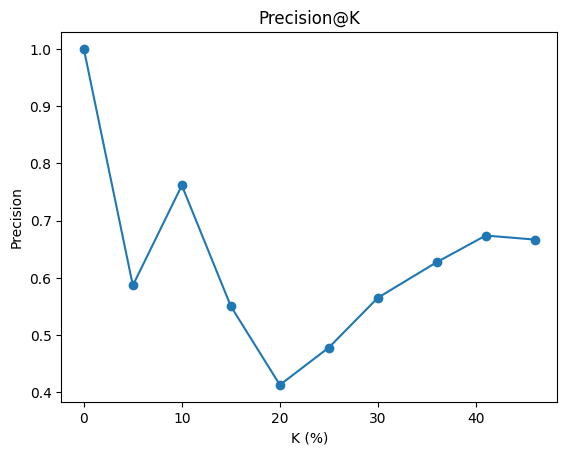

In [64]:
precision_values, total_k = precision_at_k(model, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()

In [ ]:
import copy
best_precision = 0
roc = []
accuracy = []
precision = []
recall = []
for i in range(10):
    LARGE_FEATURES = True
    NEG_SAMPLES = True
    data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                            edge_index_inst_to_supp=edge_index_inst_to_supp, 
                            large_features=LARGE_FEATURES)
    train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
    
    sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
    model = gat.Model(hidden_channels=64, num_heads=4, data=data, large_features=LARGE_FEATURES)
    model = gat.gat_train(model, sampled_data, train_loader, NEG_SAMPLES)

    test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
    metric_data = validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

    roc.append(metric_data['roc_auc'])
    accuracy.append(metric_data['accuracy'])
    precision.append(metric_data['precision'])
    recall.append(metric_data['recall'])

    if metric_data['precision']>best_precision:
        best_precision = metric_data['precision']
        copied_model = copy.deepcopy(model)

    if not i%2:
        print("Iteration", i)

precision_values, total_k = precision_at_k(copied_model, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

print("ROC-AUC", np.array(roc).mean())
print("Accuracy", np.array(accuracy).mean())
print("Precision", np.array(precision).mean())
print("Recall", np.array(recall).mean())

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()
    

# Multiple Iterations

## SageCONV

### Reduced Features (25 features for supplier and 25 for institutions)

Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 78.11it/s]


Epoch: 001, Loss: 0.6072


100%|██████████| 140/140 [00:01<00:00, 81.46it/s]


Epoch: 002, Loss: 0.5877


100%|██████████| 140/140 [00:01<00:00, 73.38it/s]


Epoch: 003, Loss: 0.5758


100%|██████████| 140/140 [00:02<00:00, 67.07it/s]


Epoch: 004, Loss: 0.5688


100%|██████████| 52/52 [00:00<00:00, 68.78it/s]


Iteration 0
Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 63.51it/s]


Epoch: 001, Loss: 0.6058


100%|██████████| 140/140 [00:02<00:00, 68.37it/s]


Epoch: 002, Loss: 0.5834


100%|██████████| 140/140 [00:02<00:00, 63.96it/s]


Epoch: 003, Loss: 0.5726


100%|██████████| 140/140 [00:02<00:00, 59.53it/s]


Epoch: 004, Loss: 0.5644


100%|██████████| 52/52 [00:00<00:00, 81.30it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 71.64it/s]


Epoch: 001, Loss: 0.6053


100%|██████████| 140/140 [00:02<00:00, 67.48it/s]


Epoch: 002, Loss: 0.5863


100%|██████████| 140/140 [00:01<00:00, 83.97it/s]


Epoch: 003, Loss: 0.5791


100%|██████████| 140/140 [00:01<00:00, 83.56it/s]


Epoch: 004, Loss: 0.5723


100%|██████████| 52/52 [00:00<00:00, 87.39it/s]


Iteration 2
Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 68.74it/s]


Epoch: 001, Loss: 0.6075


100%|██████████| 140/140 [00:02<00:00, 69.49it/s]


Epoch: 002, Loss: 0.5870


100%|██████████| 140/140 [00:01<00:00, 83.29it/s]


Epoch: 003, Loss: 0.5799


100%|██████████| 140/140 [00:01<00:00, 83.71it/s]


Epoch: 004, Loss: 0.5727


100%|██████████| 52/52 [00:00<00:00, 74.49it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 68.61it/s]


Epoch: 001, Loss: 0.6079


100%|██████████| 140/140 [00:02<00:00, 68.42it/s]


Epoch: 002, Loss: 0.5865


100%|██████████| 140/140 [00:01<00:00, 78.67it/s]


Epoch: 003, Loss: 0.5788


100%|██████████| 140/140 [00:01<00:00, 84.28it/s]


Epoch: 004, Loss: 0.5735


100%|██████████| 52/52 [00:00<00:00, 93.31it/s]


Iteration 4
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 83.25it/s]


Epoch: 001, Loss: 0.6061


100%|██████████| 140/140 [00:01<00:00, 85.37it/s]


Epoch: 002, Loss: 0.5880


100%|██████████| 140/140 [00:01<00:00, 85.21it/s]


Epoch: 003, Loss: 0.5781


100%|██████████| 140/140 [00:01<00:00, 81.50it/s]


Epoch: 004, Loss: 0.5681


100%|██████████| 52/52 [00:00<00:00, 91.40it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 84.65it/s]


Epoch: 001, Loss: 0.6052


100%|██████████| 140/140 [00:01<00:00, 86.22it/s]


Epoch: 002, Loss: 0.5869


100%|██████████| 140/140 [00:01<00:00, 84.79it/s]


Epoch: 003, Loss: 0.5766


100%|██████████| 140/140 [00:01<00:00, 86.48it/s]


Epoch: 004, Loss: 0.5697


100%|██████████| 52/52 [00:00<00:00, 92.75it/s]


Iteration 6
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 84.52it/s]


Epoch: 001, Loss: 0.6097


100%|██████████| 140/140 [00:01<00:00, 86.29it/s]


Epoch: 002, Loss: 0.5847


100%|██████████| 140/140 [00:01<00:00, 84.16it/s]


Epoch: 003, Loss: 0.5758


100%|██████████| 140/140 [00:01<00:00, 82.58it/s]


Epoch: 004, Loss: 0.5674


100%|██████████| 52/52 [00:00<00:00, 84.80it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 82.66it/s]


Epoch: 001, Loss: 0.6040


100%|██████████| 140/140 [00:01<00:00, 80.82it/s]


Epoch: 002, Loss: 0.5855


100%|██████████| 140/140 [00:01<00:00, 82.74it/s]


Epoch: 003, Loss: 0.5757


100%|██████████| 140/140 [00:01<00:00, 83.03it/s]


Epoch: 004, Loss: 0.5690


100%|██████████| 52/52 [00:00<00:00, 83.19it/s]


Iteration 8
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 84.35it/s]


Epoch: 001, Loss: 0.6083


100%|██████████| 140/140 [00:01<00:00, 83.15it/s]


Epoch: 002, Loss: 0.5880


100%|██████████| 140/140 [00:01<00:00, 84.85it/s]


Epoch: 003, Loss: 0.5792


100%|██████████| 140/140 [00:01<00:00, 84.88it/s]


Epoch: 004, Loss: 0.5715


100%|██████████| 52/52 [00:00<00:00, 87.99it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 85.03it/s]


Epoch: 001, Loss: 0.6073


100%|██████████| 140/140 [00:01<00:00, 83.32it/s]


Epoch: 002, Loss: 0.5850


100%|██████████| 140/140 [00:01<00:00, 84.67it/s]


Epoch: 003, Loss: 0.5753


100%|██████████| 140/140 [00:01<00:00, 84.52it/s]


Epoch: 004, Loss: 0.5684


100%|██████████| 52/52 [00:00<00:00, 89.04it/s]


Iteration 10
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 86.72it/s]


Epoch: 001, Loss: 0.6063


100%|██████████| 140/140 [00:01<00:00, 84.89it/s]


Epoch: 002, Loss: 0.5867


100%|██████████| 140/140 [00:01<00:00, 86.59it/s]


Epoch: 003, Loss: 0.5780


100%|██████████| 140/140 [00:01<00:00, 86.05it/s]


Epoch: 004, Loss: 0.5717


100%|██████████| 52/52 [00:00<00:00, 90.07it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 86.04it/s]


Epoch: 001, Loss: 0.6050


100%|██████████| 140/140 [00:01<00:00, 84.42it/s]


Epoch: 002, Loss: 0.5845


100%|██████████| 140/140 [00:01<00:00, 86.27it/s]


Epoch: 003, Loss: 0.5744


100%|██████████| 140/140 [00:01<00:00, 86.26it/s]


Epoch: 004, Loss: 0.5669


100%|██████████| 52/52 [00:00<00:00, 89.93it/s]


Iteration 12
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 85.81it/s]


Epoch: 001, Loss: 0.6082


100%|██████████| 140/140 [00:01<00:00, 84.13it/s]


Epoch: 002, Loss: 0.5869


100%|██████████| 140/140 [00:01<00:00, 85.76it/s]


Epoch: 003, Loss: 0.5819


100%|██████████| 140/140 [00:01<00:00, 85.91it/s]


Epoch: 004, Loss: 0.5735


100%|██████████| 52/52 [00:00<00:00, 90.06it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 85.87it/s]


Epoch: 001, Loss: 0.6041


100%|██████████| 140/140 [00:01<00:00, 84.01it/s]


Epoch: 002, Loss: 0.5849


100%|██████████| 140/140 [00:01<00:00, 85.55it/s]


Epoch: 003, Loss: 0.5749


100%|██████████| 140/140 [00:01<00:00, 83.86it/s]


Epoch: 004, Loss: 0.5712


100%|██████████| 52/52 [00:00<00:00, 93.86it/s]


Iteration 14
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 85.17it/s]


Epoch: 001, Loss: 0.6054


100%|██████████| 140/140 [00:01<00:00, 84.58it/s]


Epoch: 002, Loss: 0.5863


100%|██████████| 140/140 [00:01<00:00, 87.69it/s]


Epoch: 003, Loss: 0.5764


100%|██████████| 140/140 [00:01<00:00, 85.05it/s]


Epoch: 004, Loss: 0.5682


100%|██████████| 52/52 [00:00<00:00, 94.23it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 86.59it/s]


Epoch: 001, Loss: 0.6058


100%|██████████| 140/140 [00:01<00:00, 81.44it/s]


Epoch: 002, Loss: 0.5879


100%|██████████| 140/140 [00:01<00:00, 83.01it/s]


Epoch: 003, Loss: 0.5782


100%|██████████| 140/140 [00:01<00:00, 79.39it/s]


Epoch: 004, Loss: 0.5684


100%|██████████| 52/52 [00:00<00:00, 88.61it/s]


Iteration 16
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 85.34it/s]


Epoch: 001, Loss: 0.6097


100%|██████████| 140/140 [00:01<00:00, 81.53it/s]


Epoch: 002, Loss: 0.5869


100%|██████████| 140/140 [00:01<00:00, 81.86it/s]


Epoch: 003, Loss: 0.5763


100%|██████████| 140/140 [00:01<00:00, 79.31it/s]


Epoch: 004, Loss: 0.5683


100%|██████████| 52/52 [00:00<00:00, 90.47it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 81.21it/s]


Epoch: 001, Loss: 0.6061


100%|██████████| 140/140 [00:01<00:00, 81.65it/s]


Epoch: 002, Loss: 0.5879


100%|██████████| 140/140 [00:01<00:00, 83.53it/s]


Epoch: 003, Loss: 0.5778


100%|██████████| 140/140 [00:01<00:00, 77.93it/s]


Epoch: 004, Loss: 0.5705


100%|██████████| 52/52 [00:00<00:00, 94.63it/s]


Iteration 18
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 81.90it/s]


Epoch: 001, Loss: 0.6063


100%|██████████| 140/140 [00:01<00:00, 85.38it/s]


Epoch: 002, Loss: 0.5892


100%|██████████| 140/140 [00:01<00:00, 85.42it/s]


Epoch: 003, Loss: 0.5802


100%|██████████| 140/140 [00:01<00:00, 83.73it/s]


Epoch: 004, Loss: 0.5696


100%|██████████| 52/52 [00:00<00:00, 93.52it/s]


ROC-AUC 0.8663774850137262
Accuracy 0.7989137540859945
Precision 0.7504049741655295
Recall 0.748170731707317


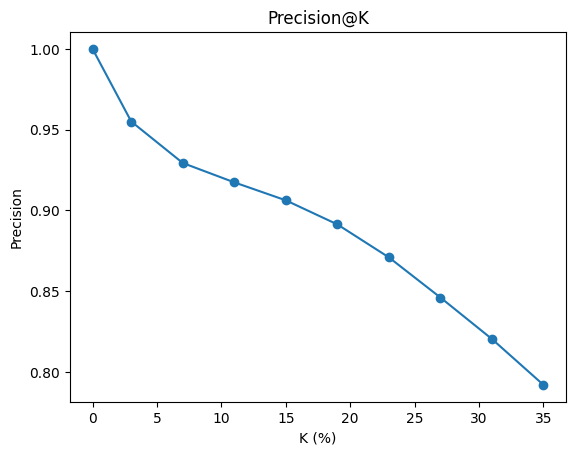

In [154]:
import copy
best_precision = 0
roc = []
accuracy = []
precision = []
recall = []
for i in range(20):
    LARGE_FEATURES = False
    NEG_SAMPLES = True
    data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                            edge_index_inst_to_supp=edge_index_inst_to_supp, 
                            large_features=LARGE_FEATURES)
    train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
    sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
    model = sageconv.Model(hidden_channels=64, data=data, large_features=LARGE_FEATURES)
    model = sageconv.sage_train(model, sampled_data, train_loader, NEG_SAMPLES)

    test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
    metric_data = validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

    roc.append(metric_data['roc_auc'])
    accuracy.append(metric_data['accuracy'])
    precision.append(metric_data['precision'])
    recall.append(metric_data['recall'])

    if metric_data['precision']>best_precision:
        best_precision = metric_data['precision']
        copied_model4 = copy.deepcopy(model)

    if not i%2:
        print("Iteration", i)

precision_values, total_k = precision_at_k(copied_model4, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

print("ROC-AUC", np.array(roc).mean())
print("Accuracy", np.array(accuracy).mean())
print("Precision", np.array(precision).mean())
print("Recall", np.array(recall).mean())

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()
    

### Large Features (34 features for supplier and 25 for institutions)

Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 81.00it/s]


Epoch: 001, Loss: 0.5980


100%|██████████| 140/140 [00:01<00:00, 81.35it/s]


Epoch: 002, Loss: 0.5777


100%|██████████| 140/140 [00:01<00:00, 79.49it/s]


Epoch: 003, Loss: 0.5664


100%|██████████| 140/140 [00:02<00:00, 63.57it/s]


Epoch: 004, Loss: 0.5614


100%|██████████| 52/52 [00:00<00:00, 89.97it/s]


Iteration 0
Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 67.74it/s]


Epoch: 001, Loss: 0.6003


100%|██████████| 140/140 [00:01<00:00, 72.67it/s]


Epoch: 002, Loss: 0.5814


100%|██████████| 140/140 [00:02<00:00, 68.32it/s]


Epoch: 003, Loss: 0.5728


100%|██████████| 140/140 [00:02<00:00, 69.22it/s]


Epoch: 004, Loss: 0.5659


100%|██████████| 52/52 [00:00<00:00, 75.38it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 65.92it/s]


Epoch: 001, Loss: 0.6006


100%|██████████| 140/140 [00:02<00:00, 66.05it/s]


Epoch: 002, Loss: 0.5756


100%|██████████| 140/140 [00:01<00:00, 78.42it/s]


Epoch: 003, Loss: 0.5696


100%|██████████| 140/140 [00:01<00:00, 81.42it/s]


Epoch: 004, Loss: 0.5641


100%|██████████| 52/52 [00:00<00:00, 91.11it/s]


Iteration 2
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 73.27it/s]


Epoch: 001, Loss: 0.5984


100%|██████████| 140/140 [00:01<00:00, 81.60it/s]


Epoch: 002, Loss: 0.5761


100%|██████████| 140/140 [00:01<00:00, 79.60it/s]


Epoch: 003, Loss: 0.5692


100%|██████████| 140/140 [00:02<00:00, 60.62it/s]


Epoch: 004, Loss: 0.5645


100%|██████████| 52/52 [00:00<00:00, 72.94it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 62.94it/s]


Epoch: 001, Loss: 0.6023


100%|██████████| 140/140 [00:02<00:00, 68.53it/s]


Epoch: 002, Loss: 0.5784


100%|██████████| 140/140 [00:01<00:00, 74.66it/s]


Epoch: 003, Loss: 0.5692


100%|██████████| 140/140 [00:01<00:00, 73.76it/s]


Epoch: 004, Loss: 0.5625


100%|██████████| 52/52 [00:00<00:00, 85.94it/s]


Iteration 4
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 77.65it/s]


Epoch: 001, Loss: 0.6003


100%|██████████| 140/140 [00:01<00:00, 82.20it/s]


Epoch: 002, Loss: 0.5757


100%|██████████| 140/140 [00:01<00:00, 80.59it/s]


Epoch: 003, Loss: 0.5674


100%|██████████| 140/140 [00:01<00:00, 82.38it/s]


Epoch: 004, Loss: 0.5637


100%|██████████| 52/52 [00:00<00:00, 92.77it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 80.87it/s]


Epoch: 001, Loss: 0.6016


100%|██████████| 140/140 [00:01<00:00, 80.15it/s]


Epoch: 002, Loss: 0.5782


100%|██████████| 140/140 [00:01<00:00, 80.68it/s]


Epoch: 003, Loss: 0.5686


100%|██████████| 140/140 [00:01<00:00, 79.45it/s]


Epoch: 004, Loss: 0.5631


100%|██████████| 52/52 [00:00<00:00, 88.30it/s]


Iteration 6
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 80.58it/s]


Epoch: 001, Loss: 0.6016


100%|██████████| 140/140 [00:01<00:00, 80.05it/s]


Epoch: 002, Loss: 0.5776


100%|██████████| 140/140 [00:01<00:00, 78.33it/s]


Epoch: 003, Loss: 0.5688


100%|██████████| 140/140 [00:01<00:00, 82.61it/s]


Epoch: 004, Loss: 0.5638


100%|██████████| 52/52 [00:00<00:00, 90.74it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 79.63it/s]


Epoch: 001, Loss: 0.6004


100%|██████████| 140/140 [00:01<00:00, 81.97it/s]


Epoch: 002, Loss: 0.5792


100%|██████████| 140/140 [00:01<00:00, 82.57it/s]


Epoch: 003, Loss: 0.5708


100%|██████████| 140/140 [00:01<00:00, 83.03it/s]


Epoch: 004, Loss: 0.5630


100%|██████████| 52/52 [00:00<00:00, 85.10it/s]


Iteration 8
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 82.26it/s]


Epoch: 001, Loss: 0.5998


100%|██████████| 140/140 [00:01<00:00, 81.39it/s]


Epoch: 002, Loss: 0.5789


100%|██████████| 140/140 [00:01<00:00, 80.21it/s]


Epoch: 003, Loss: 0.5721


100%|██████████| 140/140 [00:01<00:00, 84.30it/s]


Epoch: 004, Loss: 0.5675


100%|██████████| 52/52 [00:00<00:00, 85.67it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 82.18it/s]


Epoch: 001, Loss: 0.6026


100%|██████████| 140/140 [00:01<00:00, 80.95it/s]


Epoch: 002, Loss: 0.5799


100%|██████████| 140/140 [00:01<00:00, 84.51it/s]


Epoch: 003, Loss: 0.5708


100%|██████████| 140/140 [00:01<00:00, 78.96it/s]


Epoch: 004, Loss: 0.5645


100%|██████████| 52/52 [00:00<00:00, 94.24it/s]


Iteration 10
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 83.14it/s]


Epoch: 001, Loss: 0.6008


100%|██████████| 140/140 [00:01<00:00, 82.92it/s]


Epoch: 002, Loss: 0.5820


100%|██████████| 140/140 [00:01<00:00, 83.49it/s]


Epoch: 003, Loss: 0.5712


100%|██████████| 140/140 [00:01<00:00, 79.92it/s]


Epoch: 004, Loss: 0.5663


100%|██████████| 52/52 [00:00<00:00, 94.08it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 82.44it/s]


Epoch: 001, Loss: 0.6027


100%|██████████| 140/140 [00:01<00:00, 78.26it/s]


Epoch: 002, Loss: 0.5813


100%|██████████| 140/140 [00:01<00:00, 82.72it/s]


Epoch: 003, Loss: 0.5711


100%|██████████| 140/140 [00:01<00:00, 81.79it/s]


Epoch: 004, Loss: 0.5664


100%|██████████| 52/52 [00:00<00:00, 93.81it/s]


Iteration 12
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 80.92it/s]


Epoch: 001, Loss: 0.6004


100%|██████████| 140/140 [00:01<00:00, 82.80it/s]


Epoch: 002, Loss: 0.5764


100%|██████████| 140/140 [00:01<00:00, 82.44it/s]


Epoch: 003, Loss: 0.5682


100%|██████████| 140/140 [00:01<00:00, 80.75it/s]


Epoch: 004, Loss: 0.5638


100%|██████████| 52/52 [00:00<00:00, 91.44it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 81.15it/s]


Epoch: 001, Loss: 0.6029


100%|██████████| 140/140 [00:01<00:00, 83.23it/s]


Epoch: 002, Loss: 0.5802


100%|██████████| 140/140 [00:01<00:00, 81.14it/s]


Epoch: 003, Loss: 0.5722


100%|██████████| 140/140 [00:01<00:00, 79.69it/s]


Epoch: 004, Loss: 0.5663


100%|██████████| 52/52 [00:00<00:00, 92.28it/s]


Iteration 14
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 80.98it/s]


Epoch: 001, Loss: 0.5998


100%|██████████| 140/140 [00:01<00:00, 83.31it/s]


Epoch: 002, Loss: 0.5760


100%|██████████| 140/140 [00:01<00:00, 80.13it/s]


Epoch: 003, Loss: 0.5660


100%|██████████| 140/140 [00:02<00:00, 66.69it/s]


Epoch: 004, Loss: 0.5609


100%|██████████| 52/52 [00:00<00:00, 80.89it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 63.97it/s]


Epoch: 001, Loss: 0.5994


100%|██████████| 140/140 [00:02<00:00, 56.20it/s]


Epoch: 002, Loss: 0.5788


100%|██████████| 140/140 [00:02<00:00, 64.55it/s]


Epoch: 003, Loss: 0.5717


100%|██████████| 140/140 [00:02<00:00, 64.26it/s]


Epoch: 004, Loss: 0.5639


100%|██████████| 52/52 [00:00<00:00, 84.59it/s]


Iteration 16
Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 69.53it/s]


Epoch: 001, Loss: 0.6027


100%|██████████| 140/140 [00:01<00:00, 76.88it/s]


Epoch: 002, Loss: 0.5782


100%|██████████| 140/140 [00:01<00:00, 79.07it/s]


Epoch: 003, Loss: 0.5694


100%|██████████| 140/140 [00:01<00:00, 75.86it/s]


Epoch: 004, Loss: 0.5653


100%|██████████| 52/52 [00:00<00:00, 72.84it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:02<00:00, 64.74it/s]


Epoch: 001, Loss: 0.6051


100%|██████████| 140/140 [00:01<00:00, 72.54it/s]


Epoch: 002, Loss: 0.5803


100%|██████████| 140/140 [00:01<00:00, 77.63it/s]


Epoch: 003, Loss: 0.5716


100%|██████████| 140/140 [00:01<00:00, 77.15it/s]


Epoch: 004, Loss: 0.5678


100%|██████████| 52/52 [00:00<00:00, 65.14it/s]


Iteration 18
Device: 'cpu'


100%|██████████| 140/140 [00:01<00:00, 76.74it/s]


Epoch: 001, Loss: 0.5996


100%|██████████| 140/140 [00:01<00:00, 72.39it/s]


Epoch: 002, Loss: 0.5769


100%|██████████| 140/140 [00:01<00:00, 71.32it/s]


Epoch: 003, Loss: 0.5700


100%|██████████| 140/140 [00:01<00:00, 77.42it/s]


Epoch: 004, Loss: 0.5650


100%|██████████| 52/52 [00:00<00:00, 88.07it/s]


ROC-AUC 0.8820370723142437
Accuracy 0.8147699270807142
Precision 0.7857312486683056
Recall 0.7407405079205432


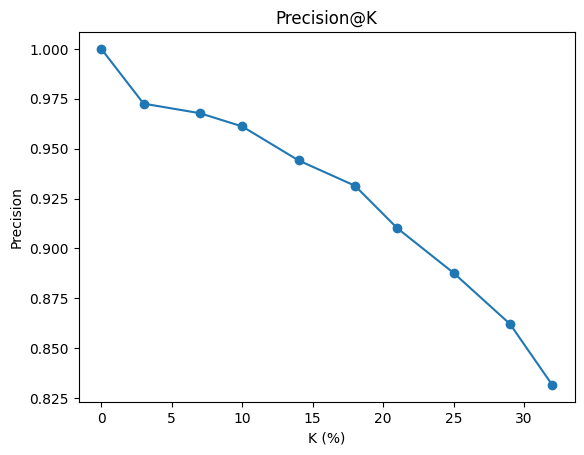

In [155]:
import copy
best_precision = 0
roc = []
accuracy = []
precision = []
recall = []
for i in range(20):
    LARGE_FEATURES = True
    NEG_SAMPLES = True
    data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                            edge_index_inst_to_supp=edge_index_inst_to_supp, 
                            large_features=LARGE_FEATURES)
    train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
    sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
    model = sageconv.Model(hidden_channels=64, data=data, large_features=LARGE_FEATURES)
    model = sageconv.sage_train(model, sampled_data, train_loader, NEG_SAMPLES)

    test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
    metric_data = validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

    roc.append(metric_data['roc_auc'])
    accuracy.append(metric_data['accuracy'])
    precision.append(metric_data['precision'])
    recall.append(metric_data['recall'])

    if metric_data['precision']>best_precision:
        best_precision = metric_data['precision']
        copied_model = copy.deepcopy(model)

    if not i%2:
        print("Iteration", i)

precision_values, total_k = precision_at_k(copied_model, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

print("ROC-AUC", np.array(roc).mean())
print("Accuracy", np.array(accuracy).mean())
print("Precision", np.array(precision).mean())
print("Recall", np.array(recall).mean())

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()
    

## GAT

### Reduced Features (25 features for supplier and 25 for institutions)

Device: 'cpu'


  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:06<00:00, 20.27it/s]


Epoch: 001, Loss: 0.6162


100%|██████████| 140/140 [00:06<00:00, 21.17it/s]


Epoch: 002, Loss: 0.6025


100%|██████████| 140/140 [08:12<00:00,  3.51s/it]


Epoch: 003, Loss: 0.5976


100%|██████████| 140/140 [00:06<00:00, 21.01it/s]


Epoch: 004, Loss: 0.5934


100%|██████████| 52/52 [00:01<00:00, 34.45it/s]


Iteration 0
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.31it/s]


Epoch: 001, Loss: 0.6120


100%|██████████| 140/140 [00:06<00:00, 21.54it/s]


Epoch: 002, Loss: 0.5969


100%|██████████| 140/140 [00:06<00:00, 22.44it/s]


Epoch: 003, Loss: 0.5944


100%|██████████| 140/140 [00:06<00:00, 21.92it/s]


Epoch: 004, Loss: 0.5920


100%|██████████| 52/52 [00:01<00:00, 36.29it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.85it/s]


Epoch: 001, Loss: 0.6160


100%|██████████| 140/140 [00:32<00:00,  4.25it/s]


Epoch: 002, Loss: 0.5980


100%|██████████| 140/140 [00:07<00:00, 17.75it/s]


Epoch: 003, Loss: 0.5980


100%|██████████| 140/140 [00:06<00:00, 20.75it/s]


Epoch: 004, Loss: 0.5986


100%|██████████| 52/52 [00:01<00:00, 35.18it/s]


Iteration 2
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.99it/s]


Epoch: 001, Loss: 0.6135


100%|██████████| 140/140 [00:06<00:00, 20.86it/s]


Epoch: 002, Loss: 0.5964


100%|██████████| 140/140 [00:06<00:00, 21.61it/s]


Epoch: 003, Loss: 0.5958


100%|██████████| 140/140 [00:06<00:00, 21.66it/s]


Epoch: 004, Loss: 0.5928


100%|██████████| 52/52 [00:01<00:00, 36.40it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.51it/s]


Epoch: 001, Loss: 0.6115


100%|██████████| 140/140 [00:06<00:00, 21.32it/s]


Epoch: 002, Loss: 0.5938


100%|██████████| 140/140 [00:06<00:00, 20.13it/s]


Epoch: 003, Loss: 0.5927


100%|██████████| 140/140 [00:06<00:00, 20.72it/s]


Epoch: 004, Loss: 0.5917


100%|██████████| 52/52 [00:01<00:00, 35.16it/s]


Iteration 4
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.96it/s]


Epoch: 001, Loss: 0.6144


100%|██████████| 140/140 [00:06<00:00, 21.39it/s]


Epoch: 002, Loss: 0.6015


100%|██████████| 140/140 [00:06<00:00, 21.57it/s]


Epoch: 003, Loss: 0.5973


100%|██████████| 140/140 [00:06<00:00, 20.02it/s]


Epoch: 004, Loss: 0.5947


100%|██████████| 52/52 [00:01<00:00, 33.52it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 20.46it/s]


Epoch: 001, Loss: 0.6174


100%|██████████| 140/140 [00:07<00:00, 19.88it/s]


Epoch: 002, Loss: 0.6000


100%|██████████| 140/140 [00:06<00:00, 21.02it/s]


Epoch: 003, Loss: 0.5957


100%|██████████| 140/140 [00:06<00:00, 20.87it/s]


Epoch: 004, Loss: 0.5950


100%|██████████| 52/52 [00:01<00:00, 35.72it/s]


Iteration 6
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.59it/s]


Epoch: 001, Loss: 0.6214


100%|██████████| 140/140 [00:06<00:00, 21.36it/s]


Epoch: 002, Loss: 0.6031


100%|██████████| 140/140 [00:06<00:00, 21.32it/s]


Epoch: 003, Loss: 0.5958


100%|██████████| 140/140 [00:06<00:00, 21.42it/s]


Epoch: 004, Loss: 0.5955


100%|██████████| 52/52 [00:01<00:00, 34.75it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.31it/s]


Epoch: 001, Loss: 0.6110


100%|██████████| 140/140 [00:06<00:00, 20.82it/s]


Epoch: 002, Loss: 0.5972


100%|██████████| 140/140 [00:07<00:00, 19.83it/s]


Epoch: 003, Loss: 0.5949


100%|██████████| 140/140 [00:06<00:00, 20.70it/s]


Epoch: 004, Loss: 0.5929


100%|██████████| 52/52 [00:01<00:00, 35.40it/s]


Iteration 8
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.08it/s]


Epoch: 001, Loss: 0.6184


100%|██████████| 140/140 [00:06<00:00, 21.01it/s]


Epoch: 002, Loss: 0.5986


100%|██████████| 140/140 [00:06<00:00, 20.88it/s]


Epoch: 003, Loss: 0.5933


100%|██████████| 140/140 [00:06<00:00, 21.02it/s]


Epoch: 004, Loss: 0.6011


100%|██████████| 52/52 [00:01<00:00, 35.19it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.30it/s]


Epoch: 001, Loss: 0.6143


100%|██████████| 140/140 [00:06<00:00, 21.61it/s]


Epoch: 002, Loss: 0.6018


100%|██████████| 140/140 [00:06<00:00, 21.48it/s]


Epoch: 003, Loss: 0.5936


100%|██████████| 140/140 [00:06<00:00, 21.41it/s]


Epoch: 004, Loss: 0.5956


100%|██████████| 52/52 [00:01<00:00, 35.12it/s]


Iteration 10
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.69it/s]


Epoch: 001, Loss: 0.6154


100%|██████████| 140/140 [00:06<00:00, 21.55it/s]


Epoch: 002, Loss: 0.6020


100%|██████████| 140/140 [00:06<00:00, 21.20it/s]


Epoch: 003, Loss: 0.5945


100%|██████████| 140/140 [00:06<00:00, 21.28it/s]


Epoch: 004, Loss: 0.5975


100%|██████████| 52/52 [00:01<00:00, 35.26it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.28it/s]


Epoch: 001, Loss: 0.6170


100%|██████████| 140/140 [00:06<00:00, 21.28it/s]


Epoch: 002, Loss: 0.5999


100%|██████████| 140/140 [00:06<00:00, 20.75it/s]


Epoch: 003, Loss: 0.5960


100%|██████████| 140/140 [00:06<00:00, 21.02it/s]


Epoch: 004, Loss: 0.5949


100%|██████████| 52/52 [00:01<00:00, 35.49it/s]


Iteration 12
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.27it/s]


Epoch: 001, Loss: 0.6149


100%|██████████| 140/140 [00:06<00:00, 21.36it/s]


Epoch: 002, Loss: 0.5925


100%|██████████| 140/140 [00:06<00:00, 21.25it/s]


Epoch: 003, Loss: 0.5929


100%|██████████| 140/140 [00:06<00:00, 21.23it/s]


Epoch: 004, Loss: 0.5926


100%|██████████| 52/52 [00:01<00:00, 35.81it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.46it/s]


Epoch: 001, Loss: 0.6137


100%|██████████| 140/140 [00:06<00:00, 21.67it/s]


Epoch: 002, Loss: 0.5974


100%|██████████| 140/140 [00:06<00:00, 21.50it/s]


Epoch: 003, Loss: 0.5985


100%|██████████| 140/140 [00:06<00:00, 21.45it/s]


Epoch: 004, Loss: 0.5947


100%|██████████| 52/52 [00:01<00:00, 36.59it/s]


Iteration 14
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.01it/s]


Epoch: 001, Loss: 0.6161


100%|██████████| 140/140 [00:06<00:00, 21.88it/s]


Epoch: 002, Loss: 0.5996


100%|██████████| 140/140 [00:06<00:00, 21.49it/s]


Epoch: 003, Loss: 0.5929


100%|██████████| 140/140 [00:06<00:00, 21.37it/s]


Epoch: 004, Loss: 0.5884


100%|██████████| 52/52 [00:01<00:00, 35.50it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.52it/s]


Epoch: 001, Loss: 0.6167


100%|██████████| 140/140 [00:06<00:00, 21.19it/s]


Epoch: 002, Loss: 0.6019


100%|██████████| 140/140 [00:06<00:00, 21.33it/s]


Epoch: 003, Loss: 0.5928


100%|██████████| 140/140 [00:06<00:00, 21.45it/s]


Epoch: 004, Loss: 0.5966


100%|██████████| 52/52 [00:01<00:00, 35.26it/s]


Iteration 16
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.76it/s]


Epoch: 001, Loss: 0.6168


100%|██████████| 140/140 [00:06<00:00, 21.46it/s]


Epoch: 002, Loss: 0.6009


100%|██████████| 140/140 [00:06<00:00, 21.48it/s]


Epoch: 003, Loss: 0.5953


100%|██████████| 140/140 [00:06<00:00, 21.67it/s]


Epoch: 004, Loss: 0.5997


100%|██████████| 52/52 [00:01<00:00, 34.79it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.54it/s]


Epoch: 001, Loss: 0.6157


100%|██████████| 140/140 [00:06<00:00, 21.36it/s]


Epoch: 002, Loss: 0.5983


100%|██████████| 140/140 [00:06<00:00, 21.32it/s]


Epoch: 003, Loss: 0.5952


100%|██████████| 140/140 [00:06<00:00, 21.37it/s]


Epoch: 004, Loss: 0.5979


100%|██████████| 52/52 [00:01<00:00, 35.06it/s]


Iteration 18
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.92it/s]


Epoch: 001, Loss: 0.6112


100%|██████████| 140/140 [00:06<00:00, 21.86it/s]


Epoch: 002, Loss: 0.5971


100%|██████████| 140/140 [00:06<00:00, 21.67it/s]


Epoch: 003, Loss: 0.5924


100%|██████████| 140/140 [00:06<00:00, 21.88it/s]


Epoch: 004, Loss: 0.5929


100%|██████████| 52/52 [00:01<00:00, 36.28it/s]


ROC-AUC 0.7862678035532742
Accuracy 0.7536409353784259
Precision 0.698125041447934
Recall 0.7137855167211465


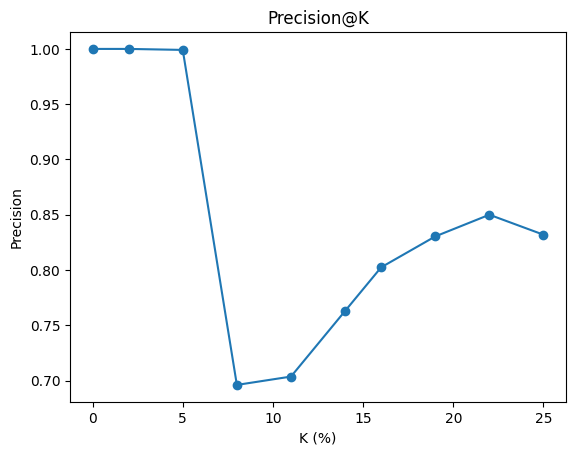

In [113]:
import copy
best_precision = 0
roc = []
accuracy = []
precision = []
recall = []
for i in range(20):
    LARGE_FEATURES = False
    NEG_SAMPLES = True
    data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                            edge_index_inst_to_supp=edge_index_inst_to_supp, 
                            large_features=LARGE_FEATURES)
    train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
    
    sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
    model = gat.Model(hidden_channels=64, num_heads=4, data=data, large_features=LARGE_FEATURES)
    model = gat.gat_train(model, sampled_data, train_loader, NEG_SAMPLES)

    test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
    metric_data = validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

    roc.append(metric_data['roc_auc'])
    accuracy.append(metric_data['accuracy'])
    precision.append(metric_data['precision'])
    recall.append(metric_data['recall'])

    if metric_data['precision']>best_precision:
        best_precision = metric_data['precision']
        copied_model3 = copy.deepcopy(model)

    if not i%2:
        print("Iteration", i)

precision_values, total_k = precision_at_k(copied_model3, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

print("ROC-AUC", np.array(roc).mean())
print("Accuracy", np.array(accuracy).mean())
print("Precision", np.array(precision).mean())
print("Recall", np.array(recall).mean())

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()
    

### Large Features (34 features for supplier and 25 for institutions)

Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 20.66it/s]


Epoch: 001, Loss: 0.6101


100%|██████████| 140/140 [00:06<00:00, 20.62it/s]


Epoch: 002, Loss: 0.5949


100%|██████████| 140/140 [00:07<00:00, 17.73it/s]


Epoch: 003, Loss: 0.5919


100%|██████████| 140/140 [00:06<00:00, 20.28it/s]


Epoch: 004, Loss: 0.5922


100%|██████████| 52/52 [00:01<00:00, 32.81it/s]


Iteration 0
Device: 'cpu'


100%|██████████| 140/140 [00:07<00:00, 19.54it/s]


Epoch: 001, Loss: 0.6149


100%|██████████| 140/140 [00:06<00:00, 21.08it/s]


Epoch: 002, Loss: 0.6029


100%|██████████| 140/140 [00:06<00:00, 21.80it/s]


Epoch: 003, Loss: 0.5927


100%|██████████| 140/140 [00:06<00:00, 20.71it/s]


Epoch: 004, Loss: 0.5902


100%|██████████| 52/52 [00:01<00:00, 35.14it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.00it/s]


Epoch: 001, Loss: 0.6138


100%|██████████| 140/140 [00:08<00:00, 17.46it/s]


Epoch: 002, Loss: 0.6023


100%|██████████| 140/140 [00:06<00:00, 20.50it/s]


Epoch: 003, Loss: 0.5937


100%|██████████| 140/140 [00:06<00:00, 20.86it/s]


Epoch: 004, Loss: 0.5894


100%|██████████| 52/52 [00:01<00:00, 29.80it/s]


Iteration 2
Device: 'cpu'


100%|██████████| 140/140 [00:07<00:00, 19.76it/s]


Epoch: 001, Loss: 0.6155


100%|██████████| 140/140 [00:06<00:00, 20.88it/s]


Epoch: 002, Loss: 0.5985


100%|██████████| 140/140 [00:06<00:00, 20.72it/s]


Epoch: 003, Loss: 0.5951


100%|██████████| 140/140 [00:06<00:00, 21.10it/s]


Epoch: 004, Loss: 0.5855


100%|██████████| 52/52 [00:01<00:00, 34.05it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 20.11it/s]


Epoch: 001, Loss: 0.6174


100%|██████████| 140/140 [00:07<00:00, 18.98it/s]


Epoch: 002, Loss: 0.5948


100%|██████████| 140/140 [00:06<00:00, 20.47it/s]


Epoch: 003, Loss: 0.5927


100%|██████████| 140/140 [00:07<00:00, 18.70it/s]


Epoch: 004, Loss: 0.5922


100%|██████████| 52/52 [00:01<00:00, 33.83it/s]


Iteration 4
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 20.12it/s]


Epoch: 001, Loss: 0.6113


100%|██████████| 140/140 [00:06<00:00, 20.67it/s]


Epoch: 002, Loss: 0.5951


100%|██████████| 140/140 [00:06<00:00, 20.41it/s]


Epoch: 003, Loss: 0.5882


100%|██████████| 140/140 [00:06<00:00, 20.28it/s]


Epoch: 004, Loss: 0.5938


100%|██████████| 52/52 [00:01<00:00, 32.07it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 20.55it/s]


Epoch: 001, Loss: 0.6122


100%|██████████| 140/140 [00:06<00:00, 20.58it/s]


Epoch: 002, Loss: 0.5963


100%|██████████| 140/140 [00:06<00:00, 20.21it/s]


Epoch: 003, Loss: 0.5946


100%|██████████| 140/140 [00:06<00:00, 20.45it/s]


Epoch: 004, Loss: 0.5937


100%|██████████| 52/52 [00:01<00:00, 34.47it/s]


Iteration 6
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 20.21it/s]


Epoch: 001, Loss: 0.6114


100%|██████████| 140/140 [00:06<00:00, 21.26it/s]


Epoch: 002, Loss: 0.5964


100%|██████████| 140/140 [00:06<00:00, 21.39it/s]


Epoch: 003, Loss: 0.5923


100%|██████████| 140/140 [00:06<00:00, 22.05it/s]


Epoch: 004, Loss: 0.5920


100%|██████████| 52/52 [00:01<00:00, 35.81it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.55it/s]


Epoch: 001, Loss: 0.6124


100%|██████████| 140/140 [00:06<00:00, 22.03it/s]


Epoch: 002, Loss: 0.5996


100%|██████████| 140/140 [00:06<00:00, 22.12it/s]


Epoch: 003, Loss: 0.5955


100%|██████████| 140/140 [00:06<00:00, 21.99it/s]


Epoch: 004, Loss: 0.5912


100%|██████████| 52/52 [00:01<00:00, 35.82it/s]


Iteration 8
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.04it/s]


Epoch: 001, Loss: 0.6121


100%|██████████| 140/140 [00:06<00:00, 20.78it/s]


Epoch: 002, Loss: 0.5970


100%|██████████| 140/140 [00:06<00:00, 21.70it/s]


Epoch: 003, Loss: 0.5970


100%|██████████| 140/140 [00:06<00:00, 20.18it/s]


Epoch: 004, Loss: 0.5948


100%|██████████| 52/52 [00:01<00:00, 30.64it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:07<00:00, 19.32it/s]


Epoch: 001, Loss: 0.6126


100%|██████████| 140/140 [00:06<00:00, 21.18it/s]


Epoch: 002, Loss: 0.5969


100%|██████████| 140/140 [00:06<00:00, 21.84it/s]


Epoch: 003, Loss: 0.5874


100%|██████████| 140/140 [00:07<00:00, 18.42it/s]


Epoch: 004, Loss: 0.5897


100%|██████████| 52/52 [00:01<00:00, 35.69it/s]


Iteration 10
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.82it/s]


Epoch: 001, Loss: 0.6101


100%|██████████| 140/140 [00:07<00:00, 19.50it/s]


Epoch: 002, Loss: 0.5908


100%|██████████| 140/140 [00:07<00:00, 19.04it/s]


Epoch: 003, Loss: 0.5975


100%|██████████| 140/140 [00:06<00:00, 21.60it/s]


Epoch: 004, Loss: 0.5886


100%|██████████| 52/52 [00:01<00:00, 34.45it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.28it/s]


Epoch: 001, Loss: 0.6089


100%|██████████| 140/140 [00:06<00:00, 22.62it/s]


Epoch: 002, Loss: 0.5935


100%|██████████| 140/140 [00:06<00:00, 22.23it/s]


Epoch: 003, Loss: 0.5971


100%|██████████| 140/140 [00:06<00:00, 21.75it/s]


Epoch: 004, Loss: 0.5898


100%|██████████| 52/52 [00:01<00:00, 35.91it/s]


Iteration 12
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.82it/s]


Epoch: 001, Loss: 0.6117


100%|██████████| 140/140 [00:06<00:00, 21.81it/s]


Epoch: 002, Loss: 0.5925


100%|██████████| 140/140 [00:06<00:00, 21.66it/s]


Epoch: 003, Loss: 0.5927


100%|██████████| 140/140 [00:06<00:00, 20.49it/s]


Epoch: 004, Loss: 0.5902


100%|██████████| 52/52 [00:01<00:00, 32.31it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.97it/s]


Epoch: 001, Loss: 0.6082


100%|██████████| 140/140 [00:06<00:00, 22.04it/s]


Epoch: 002, Loss: 0.5933


100%|██████████| 140/140 [00:06<00:00, 21.90it/s]


Epoch: 003, Loss: 0.5888


100%|██████████| 140/140 [00:06<00:00, 21.92it/s]


Epoch: 004, Loss: 0.5903


100%|██████████| 52/52 [00:01<00:00, 35.91it/s]


Iteration 14
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.12it/s]


Epoch: 001, Loss: 0.6104


100%|██████████| 140/140 [00:06<00:00, 22.27it/s]


Epoch: 002, Loss: 0.5961


100%|██████████| 140/140 [00:06<00:00, 21.98it/s]


Epoch: 003, Loss: 0.5984


100%|██████████| 140/140 [00:06<00:00, 22.20it/s]


Epoch: 004, Loss: 0.5920


100%|██████████| 52/52 [00:01<00:00, 36.05it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.54it/s]


Epoch: 001, Loss: 0.6120


100%|██████████| 140/140 [00:06<00:00, 21.71it/s]


Epoch: 002, Loss: 0.5983


100%|██████████| 140/140 [00:06<00:00, 21.67it/s]


Epoch: 003, Loss: 0.5933


100%|██████████| 140/140 [00:06<00:00, 21.55it/s]


Epoch: 004, Loss: 0.5902


100%|██████████| 52/52 [00:01<00:00, 35.94it/s]


Iteration 16
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 22.25it/s]


Epoch: 001, Loss: 0.6135


100%|██████████| 140/140 [00:06<00:00, 22.45it/s]


Epoch: 002, Loss: 0.5936


100%|██████████| 140/140 [00:06<00:00, 20.99it/s]


Epoch: 003, Loss: 0.5901


100%|██████████| 140/140 [00:06<00:00, 21.78it/s]


Epoch: 004, Loss: 0.5889


100%|██████████| 52/52 [00:01<00:00, 35.41it/s]


Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.73it/s]


Epoch: 001, Loss: 0.6146


100%|██████████| 140/140 [00:06<00:00, 21.33it/s]


Epoch: 002, Loss: 0.5933


100%|██████████| 140/140 [00:06<00:00, 21.44it/s]


Epoch: 003, Loss: 0.5918


100%|██████████| 140/140 [00:06<00:00, 21.25it/s]


Epoch: 004, Loss: 0.5931


100%|██████████| 52/52 [00:01<00:00, 34.19it/s]


Iteration 18
Device: 'cpu'


100%|██████████| 140/140 [00:06<00:00, 21.75it/s]


Epoch: 001, Loss: 0.6078


100%|██████████| 140/140 [00:06<00:00, 21.92it/s]


Epoch: 002, Loss: 0.5915


100%|██████████| 140/140 [00:06<00:00, 20.89it/s]


Epoch: 003, Loss: 0.5912


100%|██████████| 140/140 [00:06<00:00, 21.76it/s]


Epoch: 004, Loss: 0.5933


100%|██████████| 52/52 [00:01<00:00, 35.66it/s]


ROC-AUC 0.7975314329395533
Accuracy 0.7607417651496102
Precision 0.6927023078910362
Recall 0.7408725169725925


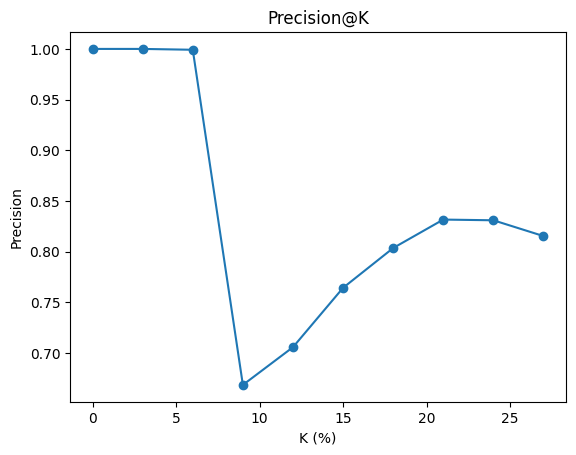

In [156]:
import copy
best_precision = 0
roc = []
accuracy = []
precision = []
recall = []
for i in range(20):
    LARGE_FEATURES = True
    NEG_SAMPLES = True
    data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                            edge_index_inst_to_supp=edge_index_inst_to_supp, 
                            large_features=LARGE_FEATURES)
    train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
    
    sampled_data, train_loader = sample_data_loader(train_data, batch_size=128, shuffle=True, neg_samp_ratio=1.5)
    model = gat.Model(hidden_channels=64, num_heads=4, data=data, large_features=LARGE_FEATURES)
    model = gat.gat_train(model, sampled_data, train_loader, NEG_SAMPLES)

    test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
    metric_data = validation_metrics(model, test_sampled_data, test_loader, set_seed=42)

    roc.append(metric_data['roc_auc'])
    accuracy.append(metric_data['accuracy'])
    precision.append(metric_data['precision'])
    recall.append(metric_data['recall'])

    if metric_data['precision']>best_precision:
        best_precision = metric_data['precision']
        copied_model2 = copy.deepcopy(model)

    if not i%2:
        print("Iteration", i)

precision_values, total_k = precision_at_k(copied_model2, test_loader)

num_points = 10
idx = np.linspace(0, len(precision_values) - 1, num_points, dtype=int)
percentage = idx * 100 // total_k

print("ROC-AUC", np.array(roc).mean())
print("Accuracy", np.array(accuracy).mean())
print("Precision", np.array(precision).mean())
print("Recall", np.array(recall).mean())

plt.plot(percentage, np.array(precision_values)[idx], 'o-')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.show()
    

## Plotting precision@k together

### GraphSAGE vs GAT

100%|██████████| 52/52 [00:01<00:00, 36.60it/s]


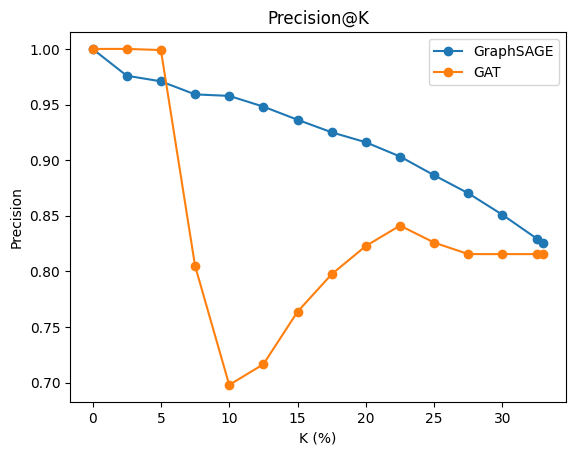

In [157]:
precision_values, total_k = precision_at_k(copied_model, test_loader)
precision_values2, _ = precision_at_k(copied_model2, test_loader)

len_prec1 = len(precision_values)
len_prec2 = len(precision_values2)

if len_prec1 > len_prec2:
    precision_values2 = [precision_values2[i] if i<len_prec2 else precision_values2[-1] for i in range(len_prec1)]
else: 
    precision_values = [precision_values[i] if i<len_prec1 else precision_values[-1] for i in range(len_prec2)]

num_points = 10
percentage = np.arange(0,len(precision_values)*100//total_k, 2.5)
percentage = np.hstack([percentage, len(precision_values)*100//total_k])
idx = (percentage*total_k//100).astype(int)

plt.plot(percentage, np.array(precision_values)[idx], 'o-', label='GraphSAGE')
plt.plot(percentage, np.array(precision_values2)[idx], 'o-', label='GAT')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.legend()
plt.show()

### Large features vs reduced features (GraphSAGE)

100%|██████████| 52/52 [00:00<00:00, 91.42it/s]


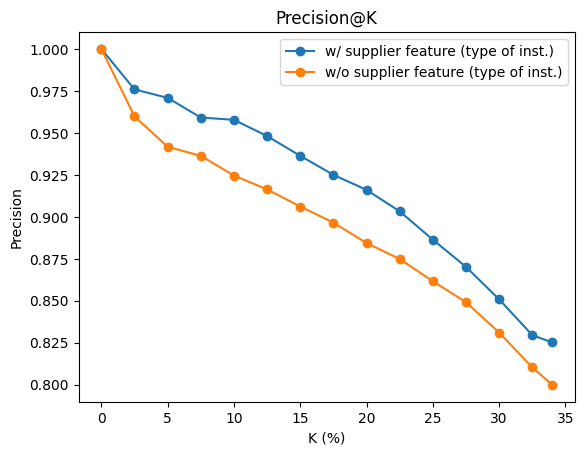

In [158]:
LARGE_FEATURES = True
NEG_SAMPLES = True
data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                        edge_index_inst_to_supp=edge_index_inst_to_supp, 
                        large_features=LARGE_FEATURES)
train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
precision_values, total_k = precision_at_k(copied_model, test_loader)

LARGE_FEATURES = False
NEG_SAMPLES = True
data = bipartite_graph_creation(feat_data=feat_data, features=features, 
                        edge_index_inst_to_supp=edge_index_inst_to_supp, 
                        large_features=LARGE_FEATURES)
train_data, val_data, test_data = split_train_validation(data, neg_samples=NEG_SAMPLES)
test_sampled_data, test_loader = sample_data_loader(test_data, batch_size=3 * 128, shuffle=False, neg_samp_ratio=None)
precision_values2, total_k2 = precision_at_k(copied_model4, test_loader)

precision_values = np.array(precision_values)
precision_values2 = np.array(precision_values2)


num_points = 10

percent1 = len(precision_values)*100//total_k
percent2 = len(precision_values2)*100//total_k2

if percent1 > percent2:
    percentage = np.arange(0,percent1, 2.5)
    percentage = np.hstack([percentage, percent1])
    idx1 = (percentage*total_k//100).astype(int)
    values1 = precision_values[idx1]
    values2 = []
    for per in percentage:
        if per < percent2:
            idx = (per*total_k//100).astype(int)
            values2.append(precision_values2[idx])
        else:
            values2.append(precision_values2[-1])
else:
    percentage = np.arange(0, percent2, 2.5)
    percentage = np.hstack([percentage, percent2])
    idx2 = (percentage*total_k2//100).astype(int)
    values2 = precision_values2[idx2]
    values1 = []
    for per in percentage:
        if per < percent1:
            idx = (per*total_k//100).astype(int)
            values1.append(precision_values[idx])
        else:
            values1.append(precision_values[-1])


plt.plot(percentage, values1, 'o-', label='w/ supplier feature (type of inst.)')
plt.plot(percentage, values2, 'o-', label='w/o supplier feature (type of inst.)')
plt.title('Precision@K')
plt.ylabel('Precision')
plt.xlabel('K (%)')
plt.legend()
plt.show()